## 1. Loading the Twitter Sentiment Dataset

We start by downloading the two CSV files from the Kaggle dataset
`epl-teams-twitter-sentiment-dataset`. We then concatenate them into a single
DataFrame and keep only the columns needed for our analysis:

- `date`: timestamp of the tweet  
- `club`: club label inferred from file name  
- `user`: Twitter handle  
- `text`: tweet text  
- `retweets`: retweet count  
- `sentiment`: VADER compound score in \[-1, 1]


In [24]:
import kagglehub
import pandas as pd
import os

from matplotlib import pyplot as plt  # used later
import networkx as nx                  # used later (keep here or re-import later)

# Scikit-learn imports for sentiment model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Download latest version of Kaggle dataset
path = kagglehub.dataset_download("wjia26/epl-teams-twitter-sentiment-dataset")
print("Path to dataset files:", path)

# Load both CSV files
csv1 = os.path.join(path, "2020-07-09 till 2020-09-19.csv")
csv2 = os.path.join(path, "2020-09-20 till 2020-10-13.csv")
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Combine them into one DataFrame and keep relevant columns
df = pd.concat([df1, df2], ignore_index=True)
df = df[['created_at', 'file_name', 'username', 'text', 'retweet_count', 'polarity']]
df.columns = ['date', 'club', 'user', 'text', 'retweets', 'sentiment']

print(df.shape)
df.head()


Path to dataset files: /Users/christofferfrost/.cache/kagglehub/datasets/wjia26/epl-teams-twitter-sentiment-dataset/versions/2
(1010582, 6)
(1010582, 6)


,date,club,user,text,retweets,sentiment
0,2020-07-09 11:34:08,Liverpool,Liverpool FC News,This is a strange claim #LFC https://t.co/U1...,0,-0.2023
1,2020-07-09 11:33:52,Liverpool,Ged Smith,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,65,0.8316
2,2020-07-09 11:33:52,Liverpool,DADA BA♐,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,32,0.8793
3,2020-07-09 11:33:50,Liverpool,Ruairi Nolan,Outrageous... Poor auld Martin Tyler has to ju...,0,-0.6808
4,2020-07-09 11:33:31,Liverpool,🇮🇪 David D'Arcy 🇮🇪,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,176,0.8176


## 2. Filter to the No-Match Transfer Window

We now:

1. Parse the tweet timestamps.
2. Drop rows with missing core metadata.
3. Restrict to the *no-match* transfer window:
   - Start: 27 July 2020 (day after the 19/20 season ends)
   - End:   11 September 2020 (day before the 20/21 season starts)

This isolates transfer-related discussion from reactions to on-pitch results.
We also print basic dataset statistics.


In [25]:
import numpy as np
import re
import os

# Parse dates and drop obvious junk
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['club', 'user', 'text'])

# Define no-match transfer window
start = pd.to_datetime("2020-07-27")
end   = pd.to_datetime("2020-09-11")

df = df[(df['date'] >= start) & (df['date'] <= end)].copy()

print(f"Filtered dataset (no matches): {len(df):,} rows, {df.shape[1]} columns")
print(f"Size: {round(df.memory_usage(deep=True).sum() / 1e6, 2)} MB")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Unique clubs: {df['club'].nunique()}")


Filtered dataset (no matches): 446,475 rows, 6 columns
Size: 243.79 MB
Date range: 2020-07-27 00:00:02 → 2020-09-10 23:59:55
Unique clubs: 12


## 3. Building the Fan–Club Bipartite Network

We construct a bipartite network:

- One node partition: **fans** (Twitter users).
- Other partition: **clubs**.
- Undirected edge between fan and club if the user tweeted about that club at least once.
- Edge weight = number of tweets from that user mentioning that club.

This network is the backbone for our later network-based analyses.


In [26]:
# Build Fan–Club bipartite network
G = nx.Graph()

for user, club in df[['user', 'club']].itertuples(index=False):
    if pd.isna(user) or pd.isna(club):
        continue
    G.add_node(user, bipartite='fan')
    G.add_node(club, bipartite='club')
    if G.has_edge(user, club):
        G[user][club]['weight'] += 1
    else:
        G.add_edge(user, club, weight=1)

fans = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'fan']
clubs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'club']

print("\nNETWORK OVERVIEW (no-match transfer window)")
print(f"Nodes: {G.number_of_nodes():,} (Fans: {len(fans):,}, Clubs: {len(clubs):,})")
print(f"Edges (fan↔club): {G.number_of_edges():,}")



NETWORK OVERVIEW (no-match transfer window)
Nodes: 127,138 (Fans: 127,126, Clubs: 12)
Edges (fan↔club): 162,015


## 4. Club-Level Sentiment Summary

Next, we aggregate tweet-level sentiment to the club level.  
For each club we compute:

- Number of tweets (`tweets`)
- Average sentiment (`avg_sentiment`)
- Average retweets (`avg_retweets`)

This reproduces the descriptive table discussed in the Results section.


In [27]:
club_sent = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment=('sentiment', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

print("\nTop clubs by tweet count (no-match window):")
print(club_sent.head(12))



Top clubs by tweet count (no-match window):
                club  tweets  avg_sentiment  avg_retweets
1            Arsenal   79993       0.225329    201.126049
9   ManchesterUnited   78916       0.229009    320.193700
7          Liverpool   74239       0.271429    133.192204
8     ManchesterCity   50385       0.213904    450.954133
11  TottenhamHotspur   45118       0.211563    275.350060
5            Everton   35186       0.270679    106.048428
3            Chelsea   21931       0.194625    135.298390
4      CrystalPalace   21356       0.214788    116.098989
6      LeicesterCity   20254       0.187106    121.808680
10       Southampton    9456       0.220887     39.965842
0    AFC Bournemouth    6144       0.243267     22.740723
2            Burnley    3497       0.200182      8.164999


## 5. Scraping Summer 2020 Transfer Data (Wikipedia)

To link financial activity to online sentiment, we scrape the official
"List of English football transfers summer 2020" page from Wikipedia.

Steps:

1. Download the HTML and parse all tables.
2. Retain only tables with `Date`, `From`, and `To` columns.
3. Standardise column names and keep the relevant columns.
4. Restrict to the same no-match window (27 July–11 September 2020).
5. Filter for Premier League clubs only.
6. Parse the transfer fee into a numeric value in **million GBP**.

The result is a table of individual transfers plus a per-club transfer spend.


In [28]:
import pandas as pd
import numpy as np
import re
import requests
from io import StringIO

url = "https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_2020"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()
html = response.text

# Read all HTML tables
tables = pd.read_html(StringIO(html))
print(f"Total tables found: {len(tables)}")

# Keep only transfer-like tables
valid_tables = []
for t in tables:
    cols = [str(c).lower() for c in t.columns]
    has_date = any("date" in c for c in cols)
    has_from = any("from" in c for c in cols)
    has_to   = any("to"   in c for c in cols)
    if has_date and has_from and has_to:
        valid_tables.append(t)

print(f"Transfer-like tables kept: {len(valid_tables)}")

transfers_df = pd.concat(valid_tables, ignore_index=True)
transfers_df = transfers_df.dropna(axis=1, how="all")

# Standardise column names
rename_map = {}
date_assigned   = False
player_assigned = False
from_assigned   = False
to_assigned     = False
fee_assigned    = False

for c in transfers_df.columns:
    cl = str(c).lower()
    if ("date" in cl) and not date_assigned:
        rename_map[c] = "Date"
        date_assigned = True
    elif ("player" in cl) and not player_assigned:
        rename_map[c] = "Player"
        player_assigned = True
    elif ("from" in cl) and not from_assigned:
        rename_map[c] = "From club"
        from_assigned = True
    elif ("to" in cl) and not to_assigned:
        rename_map[c] = "To club"
        to_assigned = True
    elif ("fee" in cl) and not fee_assigned:
        rename_map[c] = "Fee"
        fee_assigned = True

transfers_df = transfers_df.rename(columns=rename_map)
transfers_df = transfers_df.loc[:, ~transfers_df.columns.duplicated()]

keep_cols = [c for c in ["Date", "Player", "From club", "To club", "Fee"] if c in transfers_df.columns]
transfers_df = transfers_df[keep_cols].copy()

print("Columns after cleaning:", transfers_df.columns.tolist())
print("Total raw rows:", len(transfers_df))

# Filter by date
transfers_df["Date"] = pd.to_datetime(transfers_df["Date"], dayfirst=True, errors="coerce")
transfers_df = transfers_df.dropna(subset=["Date"])

start_date = "2020-07-27"
end_date   = "2020-09-11"
mask_dates = (transfers_df["Date"] >= start_date) & (transfers_df["Date"] <= end_date)
window_df = transfers_df[mask_dates].copy()
print("Rows in date window:", len(window_df))

# Keep only PL clubs (subset used in the paper)
pl_clubs = {
    "Arsenal",
    "Manchester United",
    "Liverpool",
    "Manchester City",
    "Tottenham Hotspur",
    "Everton",
    "Chelsea",
    "Crystal Palace",
    "Leicester City",
    "Southampton",
    "Burnley",
}

mask_pl = window_df["From club"].isin(pl_clubs) | window_df["To club"].isin(pl_clubs)
pl_transfers = window_df[mask_pl].copy()
print("Rows involving PL clubs:", len(pl_transfers))

def parse_fee_to_million_gbp(fee_str):
    if pd.isna(fee_str):
        return np.nan
    s = str(fee_str).lower().strip()

    if any(w in s for w in ["loan", "free", "undisclosed", "end of loan", "released"]):
        return 0.0

    s_clean = s.replace(",", "")

    m = re.search(r"£\s*([\d\.]+)\s*(m|million)", s_clean)
    if m:
        return float(m.group(1))

    k = re.search(r"£\s*([\d\.]+)\s*(k|thousand)", s_clean)
    if k:
        return float(k.group(1)) / 1000.0

    n = re.search(r"£\s*([\d\.]+)", s_clean)
    if n:
        return float(n.group(1)) / 1_000_000.0

    return np.nan

pl_transfers["Fee_clean_mGBP"] = pl_transfers["Fee"].apply(parse_fee_to_million_gbp)

# Compute club expenditure
pl_buys = pl_transfers[pl_transfers["To club"].isin(pl_clubs)].copy()
club_spend = (
    pl_buys.groupby("To club")["Fee_clean_mGBP"]
    .sum()
    .sort_values(ascending=False)
)

print("\nTotal gross spend (million GBP):")
print(club_spend)

# Save for later use
pl_transfers.to_csv("pl_transfers_2020-07-27_to_2020-09-11.csv", index=False)
club_spend.to_csv("pl_club_spend_2020-07-27_to_2020-09-11.csv")

print("\nSaved:")
print(" - pl_transfers_2020-07-27_to_2020-09-11.csv")
print(" - pl_club_spend_2020-07-27_to_2020-09-11.csv")


Total tables found: 4
Transfer-like tables kept: 2
Columns after cleaning: ['Date', 'From club', 'To club', 'Fee']
Total raw rows: 819
Rows in date window: 361
Rows involving PL clubs: 55

Total gross spend (million GBP):
To club
Chelsea              116.00
Manchester City       61.87
Everton               53.70
Manchester United     35.00
Arsenal               27.00
Leicester City        25.00
Southampton           22.90
Crystal Palace        19.50
Tottenham Hotspur     15.00
Liverpool             11.75
Burnley                0.00
Name: Fee_clean_mGBP, dtype: float64

Saved:
 - pl_transfers_2020-07-27_to_2020-09-11.csv
 - pl_club_spend_2020-07-27_to_2020-09-11.csv


## 6. Relating Transfer Spend to Average Fan Sentiment

We now merge:

- Club-level sentiment (from the Twitter dataset), and  
- Club-level transfer spend (from the scraped Wikipedia data).

Because club names may differ slightly in formatting between sources, we use a
canonical string key for matching. We then compute the Pearson correlation and
visualise the relationship between transfer spend and average sentiment.



Correlation between transfer spend and average sentiment (no-match window): -0.142


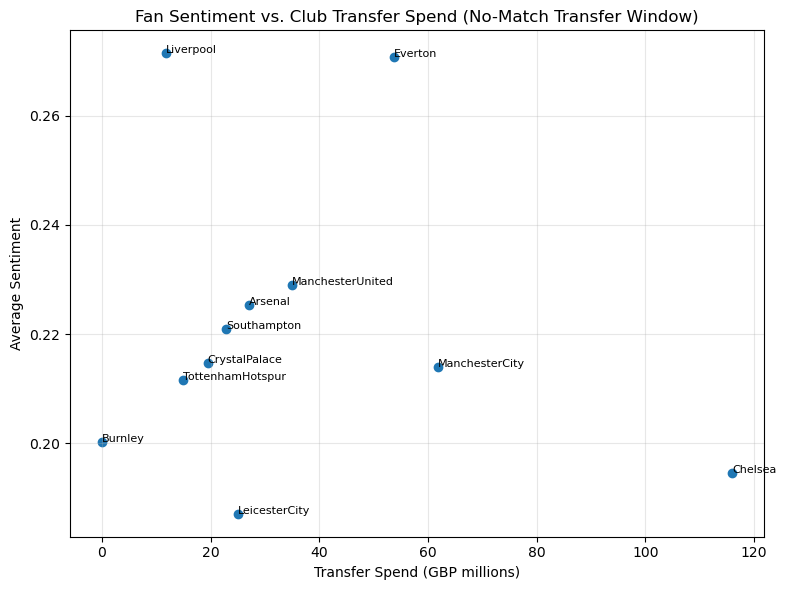

In [29]:

transfers_path = "pl_club_spend_2020-07-27_to_2020-09-11.csv"

if os.path.exists(transfers_path):
    spend = pd.read_csv(transfers_path)
    spend.columns = [c.strip().lower().replace(" ", "_") for c in spend.columns]
    spend = spend.rename(columns={
        "to_club": "club",
        "fee_clean_mgbp": "spend_gbp_m"
    })

    def canon(s):
        return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    club_sent['_key'] = club_sent['club'].apply(canon)
    spend['_key'] = spend['club'].apply(canon)

    merged = pd.merge(
        club_sent,
        spend,
        on='_key',
        how='inner',
        suffixes=('', '_spend')
    )

    if 'club_spend' in merged.columns:
        merged['club'] = merged['club'].combine_first(merged['club_spend'])

    corr = merged[['avg_sentiment', 'spend_gbp_m']].corr(method='pearson').iloc[0, 1]
    print(f"\nCorrelation between transfer spend and average sentiment (no-match window): {corr:.3f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(merged['spend_gbp_m'], merged['avg_sentiment'])
    for _, r in merged.iterrows():
        plt.text(r['spend_gbp_m'], r['avg_sentiment'], r['club'], fontsize=8)
    plt.xlabel('Transfer Spend (GBP millions)')
    plt.ylabel('Average Sentiment')
    plt.title('Fan Sentiment vs. Club Transfer Spend (No-Match Transfer Window)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Could not find 'pl_club_spend_2020-07-27_to_2020-09-11.csv'.")


## 7. Network Centrality in the Fan–Club Graph

We summarise the structure of the bipartite network:

- **Degree centrality** for clubs: proportion of fans connected to each club.
- **Strength** for clubs: total number of tweets (edge weights).
- For fans, we also compute degree and strength summary statistics.

These quantities help explain why certain clubs dominate the discussion.


In [30]:
# Safety: make sure we actually have nodes
if len(G) == 0:
    raise ValueError("Graph G is empty. Make sure you built it from df first.")

# Degree centrality (unweighted)
deg_cent = nx.degree_centrality(G)
club_deg_cent = {c: deg_cent[c] for c in clubs}

# Weighted degree (strength) = sum of edge weights
club_strength = dict(G.degree(clubs, weight='weight'))

club_centrality_df = pd.DataFrame({
    "club": list(clubs),
    "degree_centrality": [club_deg_cent[c] for c in clubs],
    "strength": [club_strength[c] for c in clubs],
}).sort_values("degree_centrality", ascending=False)

print("Top clubs by degree centrality (no-match transfer window):")
print(club_centrality_df)

fan_deg_cent = {f: deg_cent[f] for f in fans}
fan_strength = dict(G.degree(fans, weight='weight'))

fan_cent_df = pd.DataFrame({
    "fan": list(fans),
    "degree_centrality": [fan_deg_cent[f] for f in fans],
    "strength": [fan_strength[f] for f in fans],
})

print("\nFan degree stats:")
print("Mean fan degree:", np.mean([G.degree(f) for f in fans]))
print("Mean fan strength:", np.mean(list(fan_strength.values())))
print("Max fan strength:", max(list(fan_strength.values())))


Top clubs by degree centrality (no-match transfer window):
                club  degree_centrality  strength
6            Arsenal           0.219275     80172
9   ManchesterUnited           0.214808     78916
5          Liverpool           0.213400     74241
7     ManchesterCity           0.164830     50385
8   TottenhamHotspur           0.141005     45118
11           Everton           0.079096     35255
0            Chelsea           0.065009     22070
10     CrystalPalace           0.057521     21356
2      LeicesterCity           0.054327     20254
4        Southampton           0.028426      9456
3    AFC Bournemouth           0.023746      6144
1            Burnley           0.013041      3497

Fan degree stats:
Mean fan degree: 1.2742947941412457
Mean fan strength: 3.5090068121391376
Max fan strength: 3793

Fan degree stats:
Mean fan degree: 1.2742947941412457
Mean fan strength: 3.5090068121391376
Max fan strength: 3793


## 8. Sentiment Distributions by Club

To go beyond mean sentiment, we visualise the full distribution of tweet
sentiment scores per club as boxplots. This highlights differences in spread
and skewness across clubs.


<Figure size 1200x600 with 0 Axes>

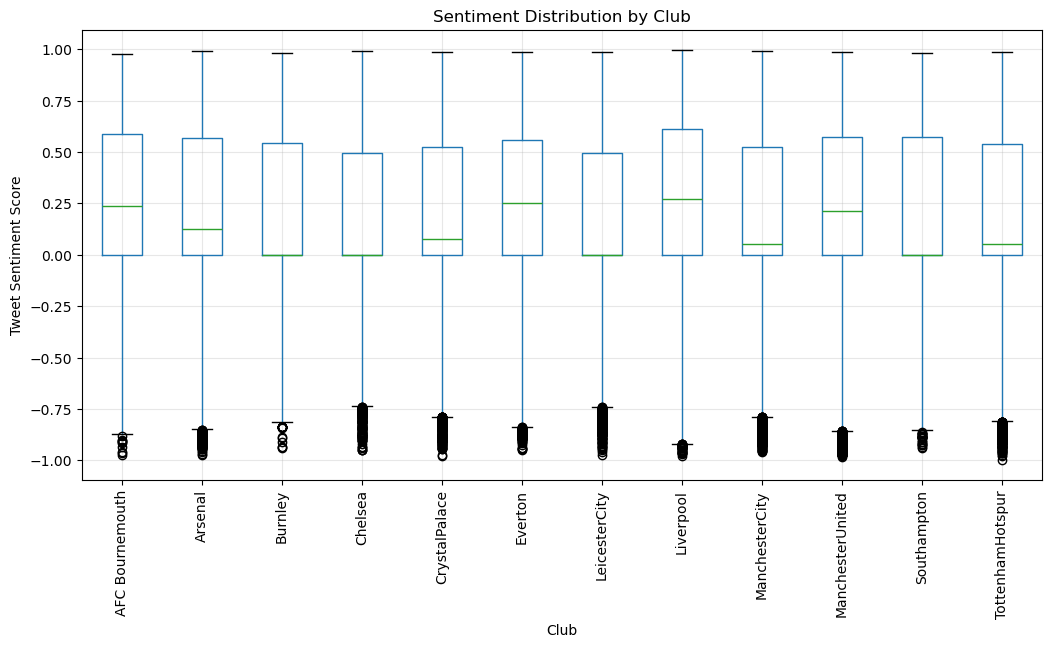

In [31]:
plt.figure(figsize=(12,6))
df.boxplot(column='sentiment', by='club', rot=90, figsize=(12,6))
plt.title("Sentiment Distribution by Club")
plt.suptitle('')
plt.xlabel("Club")
plt.ylabel("Tweet Sentiment Score")
plt.grid(alpha=0.3)
plt.show()


## 9. Fan Engagement: Tweet Volume per Club

We measure fan engagement by counting how many tweets mention each club during
the transfer window. This corresponds to the bar chart described in the text.

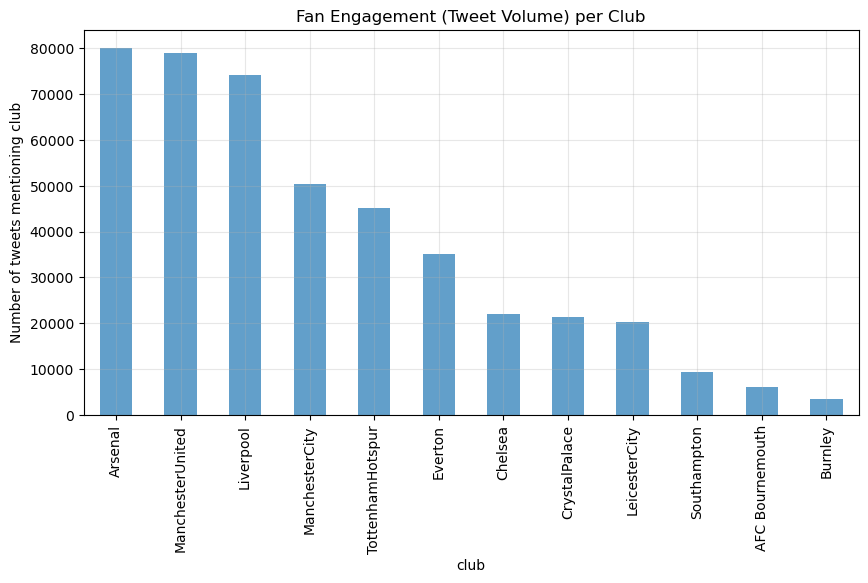

             spend_gbp_m  engagement
spend_gbp_m     1.000000   -0.040071
engagement     -0.040071    1.000000


In [32]:
club_engagement = df.groupby('club')['user'].count().sort_values(ascending=False)

plt.figure(figsize=(10,5))
club_engagement.plot(kind='bar', alpha=0.7)
plt.ylabel("Number of tweets mentioning club")
plt.title("Fan Engagement (Tweet Volume) per Club")
plt.grid(alpha=0.3)
plt.show()

# Correlation between spend and engagement (descriptive)
merge2 = merged.merge(club_engagement.rename("engagement"), on="club")
print(merge2[['spend_gbp_m','engagement']].corr())


## 10. Daily Sentiment Time Series

Finally, we examine how sentiment changes over time during the transfer window.

For each club and each day we compute the average sentiment. Plotting these
trajectories reveals sharp spikes around individual transfer events, as
described in the Results section.


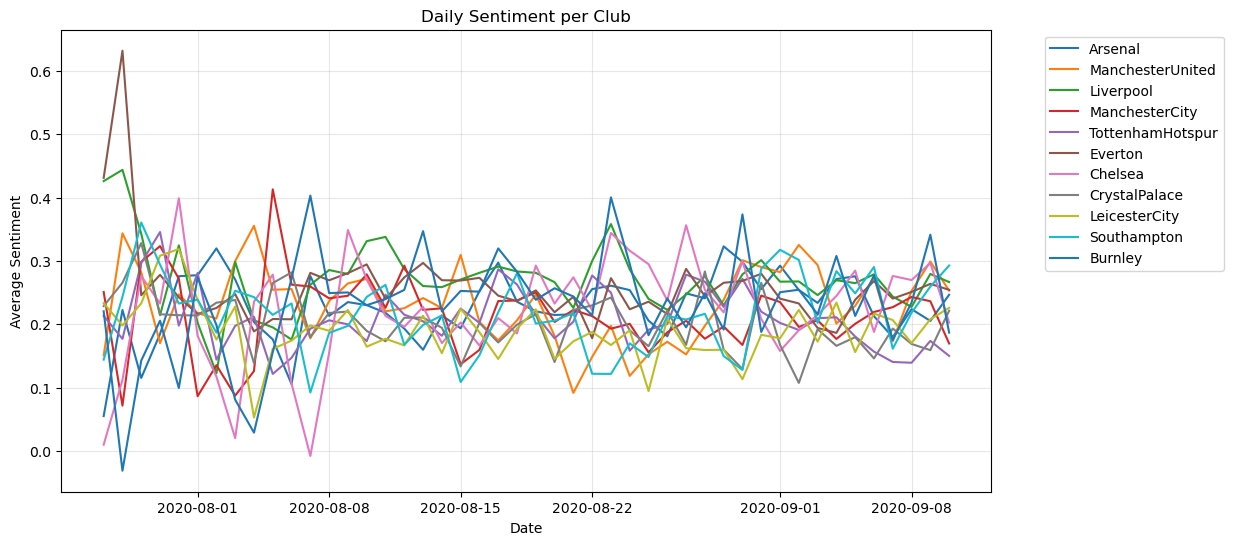

In [33]:
df['day'] = df['date'].dt.date
daily_sent = df.groupby(['club','day'])['sentiment'].mean().reset_index()

plt.figure(figsize=(12,6))
for club in merged['club'].tolist():
    subset = daily_sent[daily_sent['club'] == club]
    plt.plot(subset['day'], subset['sentiment'], label=club)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("Daily Sentiment per Club")
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.grid(alpha=0.3)
plt.show()


# 11. Self-made sentiment model (Logistic Regression on TF-IDF)

We now train our own sentiment classifier on the tweets.

Labels:
- positive: VADER sentiment > 0.2
- negative: VADER sentiment < -0.2
Neutral tweets are discarded from training.

Model:
- TF-IDF features (unigrams + bigrams),
- Logistic Regression classifier.


In [34]:
df_model = df.copy()
df_model = df_model[df_model["sentiment"].abs() > 0.2].copy()
df_model["label"] = (df_model["sentiment"] > 0.2).astype(int)

print("Training samples:", len(df_model))
print(df_model["label"].value_counts())

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=10,
    max_df=0.8,
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(df_model["text"].astype(str))
y = df_model["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nSelf-made sentiment model performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

Training samples: 267180
label
1    218784
0     48396
Name: count, dtype: int64

Self-made sentiment model performance:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      9722
           1       0.94      0.99      0.96     43714

    accuracy                           0.94     53436
   macro avg       0.93      0.85      0.88     53436
weighted avg       0.94      0.94      0.93     53436


Self-made sentiment model performance:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      9722
           1       0.94      0.99      0.96     43714

    accuracy                           0.94     53436
   macro avg       0.93      0.85      0.88     53436
weighted avg       0.94      0.94      0.93     53436



## 12. Apply Self-Made Model to All Tweets

Now we use our trained classifier to predict sentiment for all tweets in the dataset, creating a new `sentiment_ml` column with probabilities between 0 and 1.

In [35]:
# Apply the trained model to all tweets
df['text'] = df['text'].astype(str)
X_all = vectorizer.transform(df['text'])

# Predict probabilities for positive class (label=1)
df['sentiment_ml'] = clf.predict_proba(X_all)[:, 1]

# Optional: Create scaled version from [0,1] to [-1,1] to match VADER range
df['sentiment_ml_scaled'] = df['sentiment_ml'] * 2 - 1

print("\nCorrelation between VADER sentiment and ML sentiment:")
print(df["sentiment"].corr(df["sentiment_ml"]))

print(f"\nAdded sentiment_ml column to {len(df):,} tweets")
print("Sample tweets with both sentiment scores:")
df[['club', 'text', 'sentiment', 'sentiment_ml']].head()


Correlation between VADER sentiment and ML sentiment:
0.7367598241112594

Added sentiment_ml column to 446,475 tweets
Sample tweets with both sentiment scores:


,club,text,sentiment,sentiment_ml
3400,Chelsea,£50 million for Chilwell? £90 million for Have...,0.7476,0.858620
3401,Chelsea,"Which #Chelsea player, past or present is this...",0.0000,0.857420
3402,Chelsea,AC Milan are getting closer to Tiemoué Bakayok...,0.8176,0.983652
3403,Chelsea,This is a brilliant 3 minute insight from the ...,0.8176,0.979351
3404,Chelsea,#InterMilan boss #AntonioConte makes N’Golo Ka...,0.0000,0.752090
